In [1]:
%load_ext autoreload
%reload_ext tensorboard
%autoreload 2

In [2]:
import sys
sys.path.append('/home/sn/ERAv1/main_repo')

In [129]:
from torchvision import datasets, transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_lr_finder import LRFinder
from pytorch_lightning import LightningModule, Trainer
from torchmetrics import Accuracy

from models.resnet import ResNet18
from models.s10_model import s10Model
from main import train_loader, test_loader, train, test, train_losses, test_losses, train_acc, test_acc, lrs, criterion
from utils import lightning_get_incorrect_preds, plot_incorrect_preds, plot_sample_imgs, lightning_plot_gcam_incorrect_preds
# get_incorrect_preds, plot_incorrect_preds, plot_sample_imgs, plot_gcam_incorrect_preds

Files already downloaded and verified
(1600000, 32, 3)
[0.49139968 0.48215841 0.44653091] [0.24703223 0.24348513 0.26158784]


In [8]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
AVAIL_GPUS

1

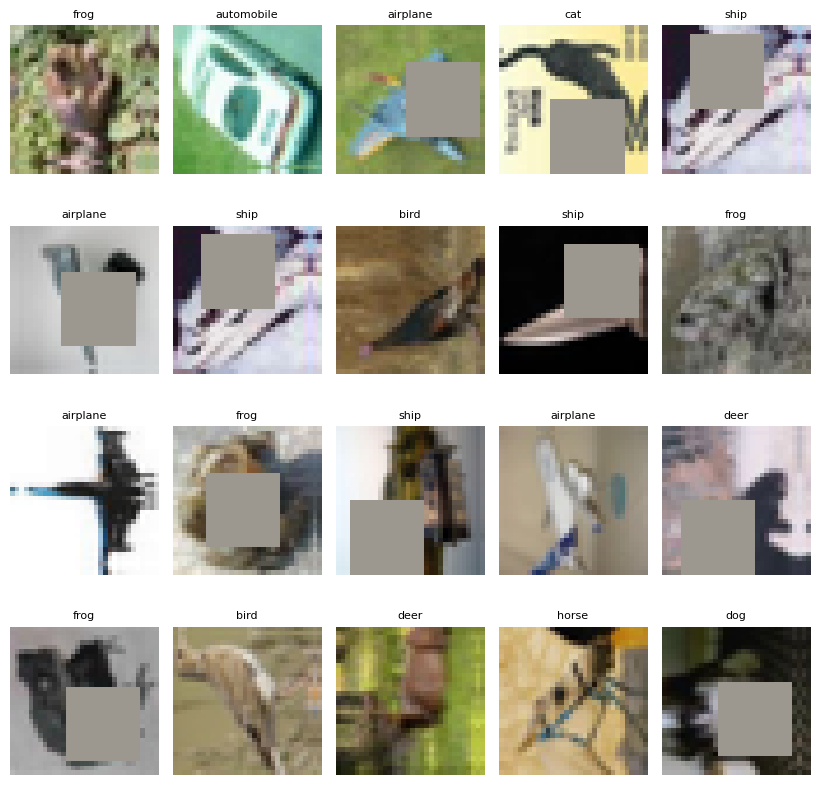

In [131]:
plot_sample_imgs(train_loader, n_figures=20)

In [37]:
from pytorch_lightning.callbacks import ModelSummary
from pytorch_lightning.callbacks import LearningRateMonitor
lr_monitor = LearningRateMonitor(logging_interval='step')

max_epochs = 24
# model = s10Model(steps_per_epoch= len(train_loader), max_epochs=max_epochs)
model = s10Model()

trainer = Trainer(
    callbacks=[ModelSummary(max_depth=-1), lr_monitor],
    devices=AVAIL_GPUS, 
    max_epochs=max_epochs,
    log_every_n_steps=20
) 
#,    enable_progress_bar=True)# progress_bar_refresh_rate=10)
#     gpus = AVAIL_GPUS,
#     max_epochs = 3,
#     progress_bar_refresh_rate=10
# )
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=test_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.

   | Name         | Type               | Params
-----------------------------------------------------
0  | criterion    | CrossEntropyLoss   | 0     
1  | accuracy     | MulticlassAccuracy | 0     
2  | preplayer    | Sequential         | 1.9 K 
3  | preplayer.0  | Conv2d             | 1.7 K 
4  | preplayer.1  | BatchNorm2d        | 128   
5  | preplayer.2  | ReLU               | 0     
6  | convblock1   | Sequential         | 74.0 K
7  | convblock1.0 | Conv2d             | 73.7 K
8  | convblock1.1 | MaxPool2d          | 0     
9  | convblock1.2 | Batch

Epoch 0: 100%|█| 98/98 [00:12<00:00,  8.02it/s, v_num=2, train_loss_step=1.680, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.32it/s]
Epoch 0: 100%|█| 98/98 [00:13<00:00,  7.41it/s, v_num=2, train_loss_step=1.680, 
Epoch 1: 100%|█| 98/98 [00:12<00:00,  7.99it/s, v_num=2, train_loss_step=1.090, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.24it/s]
Epoch 1: 100%|█| 98/98 [00:13<00:00,  7.36it/s, v_num=2, train_loss_step=1.090, 
Epoch 2: 100%|█| 98/98 [00:12<00:00,  7.97it/s, v_num=2, train_loss_step=0.873, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.15it/s]
Epoch 2: 100%|█| 98/98 [00:13<00:00,  7.35it/s, v_num=2, train_loss_step=0.873, 
Epoch 3: 100%|█| 98/98 [00:12<00:00,  7.96it/s, v_num=2, train_loss_step=0.797, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:

Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.10it/s]
Epoch 8: 100%|█| 98/98 [00:13<00:00,  7.32it/s, v_num=2, train_loss_step=0.475, 
Epoch 9: 100%|█| 98/98 [00:12<00:00,  7.93it/s, v_num=2, train_loss_step=0.514, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 21.93it/s]
Epoch 9: 100%|█| 98/98 [00:13<00:00,  7.31it/s, v_num=2, train_loss_step=0.514, 
Epoch 10: 100%|█| 98/98 [00:12<00:00,  7.91it/s, v_num=2, train_loss_step=0.483,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 21.98it/s]
Epoch 10: 100%|█| 98/98 [00:13<00:00,  7.30it/s, v_num=2, train_loss_step=0.483,
Epoch 11: 100%|█| 98/98 [00:12<00:00,  7.91it/s, v_num=2, train_loss_step=0.408,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.08it/s]
Epoch 11: 100%|█| 98/98 [00:13<00:00,  7.29it/s, v_num=2, train_loss_step=0.408,
Epoch 12: 100%|█

Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.01it/s]
Epoch 16: 100%|█| 98/98 [00:13<00:00,  7.32it/s, v_num=2, train_loss_step=0.319,
Epoch 17: 100%|█| 98/98 [00:12<00:00,  7.85it/s, v_num=2, train_loss_step=0.263,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 21.90it/s]
Epoch 17: 100%|█| 98/98 [00:13<00:00,  7.24it/s, v_num=2, train_loss_step=0.263,
Epoch 18: 100%|█| 98/98 [00:12<00:00,  7.90it/s, v_num=2, train_loss_step=0.256,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 22.08it/s]
Epoch 18: 100%|█| 98/98 [00:13<00:00,  7.29it/s, v_num=2, train_loss_step=0.256,
Epoch 19: 100%|█| 98/98 [00:12<00:00,  7.89it/s, v_num=2, train_loss_step=0.162,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  95%|█████████████████ | 19/20 [00:00<00:00, 21.96it/s]
Epoch 19: 100%|█| 98/98 [00:13<00:00,  7.27it/s, v_num=2, train_loss_step=0.162,
Epoch 20: 100%|█

`Trainer.fit` stopped: `max_epochs=24` reached.


Epoch 23: 100%|█| 98/98 [00:13<00:00,  7.18it/s, v_num=2, train_loss_step=0.111,


In [38]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████| 20/20 [00:00<00:00, 22.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_acc_epoch         0.9222000241279602
     val_loss_epoch         0.23886537551879883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': 0.23886537551879883, 'val_acc_epoch': 0.9222000241279602}]

In [1]:
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [41]:
preds = trainer.predict(trainer.model, test_loader)

preds = torch.concat(preds)

preds = preds.argmax(axis=1)

preds[:5]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████| 20/20 [00:00<00:00, 24.09it/s]


tensor([3, 8, 8, 0, 6])

In [42]:
trainer.save_checkpoint("s10Model.ckpt")

In [65]:
trainer.model
# trainer.model.resblock2[-1]

s10Model(
  (criterion): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (preplayer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (resblock1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████| 20/20 [00:00<00:00, 23.70it/s]
Classes in order Actual and Predicted


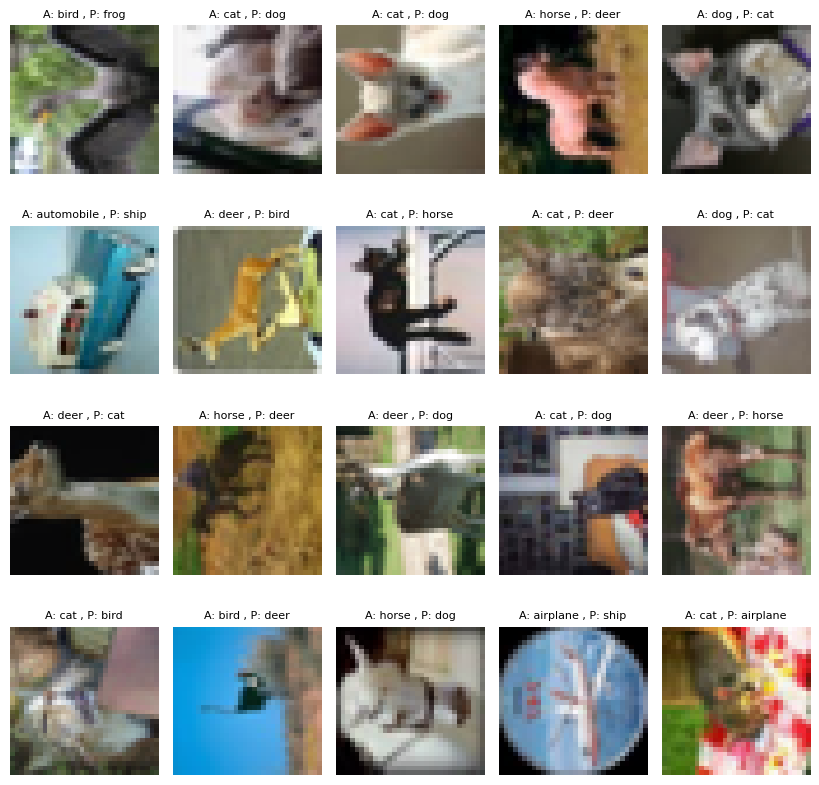

In [132]:
true_wrong, incorrect_examples, pred_wrong = lightning_get_incorrect_preds(trainer, test_loader)
plot_incorrect_preds(true_wrong, incorrect_examples, pred_wrong, n_figures=20)

Classes in order Actual and Predicted


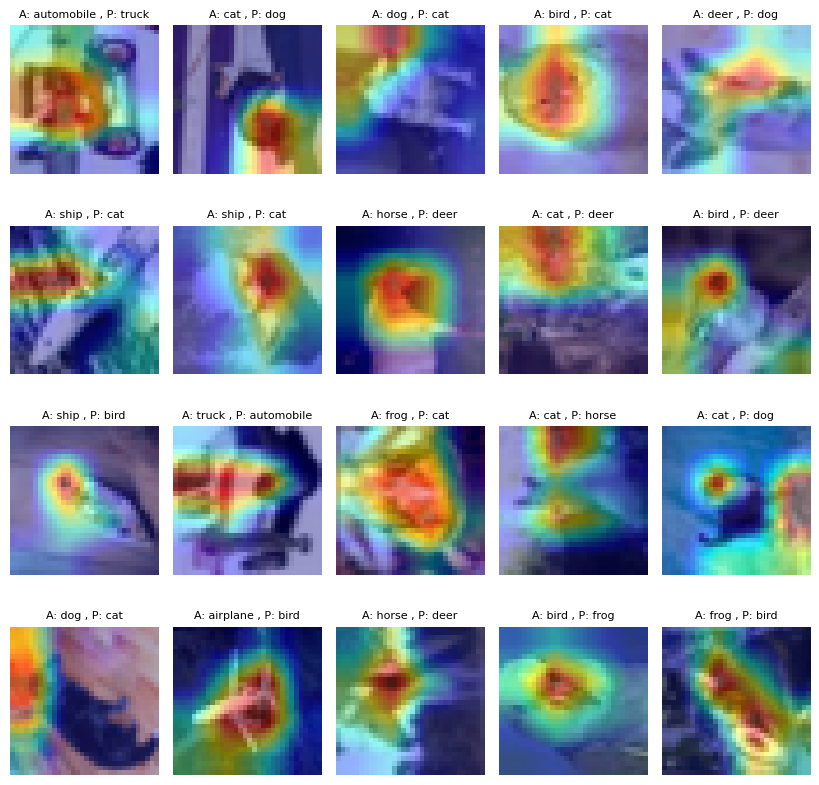

In [133]:
lightning_plot_gcam_incorrect_preds(trainer.model, true_wrong, incorrect_examples, pred_wrong, n_figures=20)

In [134]:
torch.save(trainer.model, 's10Model.pth')